# Twitter Topic Analysis of News Media - Testing number of topics

## Setup

In [1]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import utils, lda


%load_ext autoreload 
%autoreload 2

In [3]:
data = pd.read_excel('../data/nytimes_foxnews_tweets.xlsx')

In [4]:
data.head()

,Unnamed: 0,created_at,id,id_str,full_text,truncated,display_text_range,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweeted_status.quoted_status.coordinates,retweeted_status.quoted_status.place,retweeted_status.quoted_status.contributors,retweeted_status.quoted_status.is_quote_status,retweeted_status.quoted_status.retweet_count,retweeted_status.quoted_status.favorite_count,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.lang
0,0,Fri Aug 20 20:34:08 +0000 2021,1.428818e+18,1428817650549985284,Pentagon admits al Qaeda has a ‘presence’ in A...,False,"[0, 121]","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Fri Aug 20 20:30:07 +0000 2021,1.428817e+18,1428816637877276675,"When the Taliban last held Afghanistan, they b...",False,"[0, 229]","<a href=""http://www.socialflow.com"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Fri Aug 20 20:18:43 +0000 2021,1.428814e+18,1428813769866686476,"Defense Secretary Austin contradicts Biden, sa...",False,"[0, 124]","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Fri Aug 20 20:15:04 +0000 2021,1.428813e+18,1428812851070832643,RT @scottdodd: Here's how New England is prepa...,False,"[0, 140]","<a href=""http://www.socialflow.com"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Fri Aug 20 20:00:25 +0000 2021,1.428809e+18,1428809164583755776,Don’t leave home without these devices when tr...,False,"[0, 78]","<a href=""http://www.socialflow.com"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data['retweeted_status.id']

0                NaN
1                NaN
2                NaN
3       1.428787e+18
4                NaN
            ...     
1395             NaN
1396             NaN
1397             NaN
1398             NaN
1399             NaN
Name: retweeted_status.id, Length: 1400, dtype: float64

In [11]:
data['lang'] != "en".count()

TypeError: list.count() takes exactly one argument (0 given)

In [20]:
[col for col in data.columns if "retweet" in col]

['retweet_count',
 'retweeted',
 'retweeted_status.created_at',
 'retweeted_status.id',
 'retweeted_status.id_str',
 'retweeted_status.full_text',
 'retweeted_status.truncated',
 'retweeted_status.display_text_range',
 'retweeted_status.entities.hashtags',
 'retweeted_status.entities.symbols',
 'retweeted_status.entities.user_mentions',
 'retweeted_status.entities.urls',
 'retweeted_status.metadata.iso_language_code',
 'retweeted_status.metadata.result_type',
 'retweeted_status.source',
 'retweeted_status.in_reply_to_status_id',
 'retweeted_status.in_reply_to_status_id_str',
 'retweeted_status.in_reply_to_user_id',
 'retweeted_status.in_reply_to_user_id_str',
 'retweeted_status.in_reply_to_screen_name',
 'retweeted_status.user.id',
 'retweeted_status.user.id_str',
 'retweeted_status.user.name',
 'retweeted_status.user.screen_name',
 'retweeted_status.user.location',
 'retweeted_status.user.description',
 'retweeted_status.user.url',
 'retweeted_status.user.entities.url.urls',
 'retweet

In [28]:
data[(data['lang'] == 'en') & (data['retweeted_status.id'].isna())].sort_values('lang')[['full_text','lang']]

,full_text,lang
0,Pentagon admits al Qaeda has a ‘presence’ in A...,en
957,The political fallout for President Biden rema...,en
956,The British Parliament will be recalled from i...,en
955,Taliban fighters poured into Kabul on Sunday a...,en
953,The front page of The New York Times for Aug. ...,en
...,...,...
489,Hundreds of people marched against the Taliban...,en
488,In Opinion\n\n“There is good reason to believe...,en
487,"The Taliban claim to be more tolerant now, eve...",en
495,"Pelosi, top House Dems won't budge in infrastr...",en


In [4]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load and prepare test data

In [19]:
id2word, corpus = lca.notebook_process()
print(id2word[0])

academy


## Testing generated models

In [9]:
import pickle

with open("../data/models.pickle", "rb") as f:
    lda_models = pickle.load(f, encoding="utf-8")

In [10]:
models_df = pd.DataFrame([pd.Series(d, name=i) for i, d in enumerate(lda_models)])
models_df

,lda_model,n_topics,n_iter,decay,minimum_phi_value,coherence
0,"LdaModel(num_terms=4852, num_topics=1, decay=0...",1,50,0.5,0.03,0.396900
1,"LdaModel(num_terms=4852, num_topics=2, decay=0...",2,50,0.5,0.03,0.420811
2,"LdaModel(num_terms=4852, num_topics=3, decay=0...",3,50,0.5,0.03,0.445537
3,"LdaModel(num_terms=4852, num_topics=4, decay=0...",4,50,0.5,0.03,0.496699
4,"LdaModel(num_terms=4852, num_topics=5, decay=0...",5,50,0.5,0.03,0.528632
5,"LdaModel(num_terms=4852, num_topics=6, decay=0...",6,50,0.5,0.03,0.524117
6,"LdaModel(num_terms=4852, num_topics=7, decay=0...",7,50,0.5,0.03,0.528373
7,"LdaModel(num_terms=4852, num_topics=8, decay=0...",8,50,0.5,0.03,0.541721
8,"LdaModel(num_terms=4852, num_topics=9, decay=0...",9,50,0.5,0.03,0.521177
9,"LdaModel(num_terms=4852, num_topics=10, decay=...",10,50,0.5,0.03,0.532985


In [11]:
import seaborn as sns

<AxesSubplot:xlabel='n_topics', ylabel='coherence'>

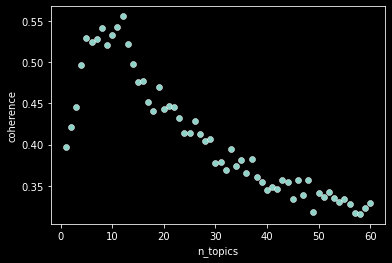

In [12]:
sns.scatterplot(data=models_df, x='n_topics', y='coherence')

In [13]:
lda_model = lda_models[11]['lda_model']

<AxesSubplot:>

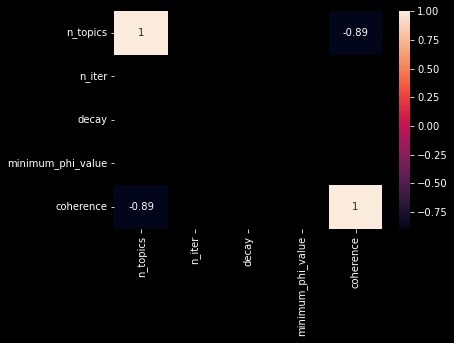

In [14]:
sns.heatmap(models_df.corr(), annot=True)

In [16]:
lda_models[11]

{'lda_model': <gensim.models.ldamodel.LdaModel at 0x1d40052c400>,
 'n_topics': 12,
 'n_iter': 50,
 'decay': 0.5,
 'minimum_phi_value': 0.03,
 'coherence': 0.5554286277375055}

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\ignac\miniconda3\envs\twitter-topics\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.132381 -0.352470       1        1  16.841379
10    -0.122936 -0.341030       2        1  14.211439
5     -0.351951 -0.100631       3        1  11.094925
2     -0.196796  0.289996       4        1   9.651541
7      0.262538 -0.161055       5        1   8.663160
0      0.312983  0.030623       6        1   7.023126
6      0.010542  0.304455       7        1   6.851242
3     -0.117237 -0.112704       8        1   6.351935
8     -0.244037  0.098597       9        1   6.296978
4      0.194650  0.242280      10        1   5.836397
9      0.133734  0.069361      11        1   4.435585
1     -0.013871  0.032577      12        1   2.742292, topic_info=             Term        Freq       Total Category  logprob  loglift
61    afghanistan  210.000000  210.000000  Default  30.0000  30.0000
44        taliban  140.000000  140.000000  Default  29.0000  29.0000
253          year   50.000000   50.000000  Default  28.0000  28.0000
240         woman   59.000000   59.000000  Default  27.0000  27.0000
268        report   35.000000   35.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1133         rent    2.671199    3.452328  Topic12  -5.1251   3.3399
1128     brooklyn    2.670705    3.451841  Topic12  -5.1253   3.3398
3237        count    2.529108    3.310218  Topic12  -5.1798   3.3272
2608        jones    2.362137    3.143249  Topic12  -5.2481   3.3107
1485        mayor    2.335124    3.116247  Topic12  -5.2596   3.3078

[412 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
766       1  0.982362      accuse
1136      3  0.981828      across
83       11  0.912083    activist
1168      4  0.939701         add
60       11  0.845123       admin
...     ...       ...         ...
253       7  0.693712        year
419       7  0.925899    year_old
25        2  0.990029        york
199       3  0.923380  york_times
412      11  0.949541       young

[392 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 6, 3, 8, 1, 7, 4, 9, 5, 10, 2])

In [21]:
topics = lda_model.show_topics(13, 10)
topics

[(0,
  '0.025*"fear" + 0.021*"week" + 0.016*"police" + 0.014*"california" + 0.014*"leader" + 0.013*"follow" + 0.013*"team" + 0.012*"hold" + 0.012*"nation" + 0.010*"keep"'),
 (1,
  '0.047*"us" + 0.025*"house" + 0.024*"claim" + 0.023*"million" + 0.021*"warn" + 0.017*"send" + 0.016*"right" + 0.015*"pose" + 0.014*"china" + 0.014*"rescue"'),
 (2,
  '0.022*"airport" + 0.020*"try" + 0.020*"know" + 0.018*"come" + 0.014*"month" + 0.014*"vaccine" + 0.014*"fall" + 0.013*"set" + 0.012*"tuesday" + 0.011*"plan"'),
 (3,
  '0.018*"military" + 0.016*"way" + 0.016*"ban" + 0.016*"flight" + 0.015*"large" + 0.015*"evacuation" + 0.014*"break" + 0.012*"find" + 0.012*"order" + 0.011*"seek"'),
 (4,
  '0.019*"monday" + 0.017*"taliban_takeover" + 0.015*"struggle" + 0.015*"rise" + 0.015*"decision" + 0.013*"collapse" + 0.013*"allow" + 0.012*"study" + 0.012*"spread" + 0.010*"start"'),
 (5,
  '0.023*"day" + 0.017*"leave" + 0.015*"american" + 0.015*"afghans" + 0.014*"haiti" + 0.013*"summer" + 0.013*"man" + 0.011*"tro

In [23]:
data = pd.read_excel('../data/nytimes_foxnews_tweets.xlsx')

In [24]:
data.head()

,Unnamed: 0,created_at,id,id_str,full_text,truncated,display_text_range,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweeted_status.quoted_status.coordinates,retweeted_status.quoted_status.place,retweeted_status.quoted_status.contributors,retweeted_status.quoted_status.is_quote_status,retweeted_status.quoted_status.retweet_count,retweeted_status.quoted_status.favorite_count,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.lang
0,0,Fri Aug 20 20:34:08 +0000 2021,1.428818e+18,1428817650549985284,Pentagon admits al Qaeda has a ‘presence’ in A...,False,"[0, 121]","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Fri Aug 20 20:30:07 +0000 2021,1.428817e+18,1428816637877276675,"When the Taliban last held Afghanistan, they b...",False,"[0, 229]","<a href=""http://www.socialflow.com"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Fri Aug 20 20:18:43 +0000 2021,1.428814e+18,1428813769866686476,"Defense Secretary Austin contradicts Biden, sa...",False,"[0, 124]","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Fri Aug 20 20:15:04 +0000 2021,1.428813e+18,1428812851070832643,RT @scottdodd: Here's how New England is prepa...,False,"[0, 140]","<a href=""http://www.socialflow.com"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Fri Aug 20 20:00:25 +0000 2021,1.428809e+18,1428809164583755776,Don’t leave home without these devices when tr...,False,"[0, 78]","<a href=""http://www.socialflow.com"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
TEST_NO = 497

test = lda_model.get_document_topics(corpus)
print(data.loc[TEST_NO, 'user.screen_name'], "\n", data.full_text[TEST_NO])
test_topics_p = [[topic[1] for topic in test[TEST_NO]]]
print(topics[np.argmax(test_topics_p)])
pd.DataFrame(test[TEST_NO])[[1]].T.style.background_gradient(axis=1)

nytimes 
 While the absolute numbers remain low, new data on breakthrough coronavirus infections indicates a change in how vaccinated Americans might regard their risk of getting Covid. But it's still "a pandemic of the unvaccinated," federal health officials say. https://t.co/uvKjGFgPiZ
(4, '0.019*"monday" + 0.017*"taliban_takeover" + 0.015*"struggle" + 0.015*"rise" + 0.015*"decision" + 0.013*"collapse" + 0.013*"allow" + 0.012*"study" + 0.012*"spread" + 0.010*"start"')


,0,1,2,3,4,5,6,7,8,9,10
1,0.014525,0.194445,0.087181,0.011980,0.286879,0.017194,0.074705,0.013896,0.097686,0.087481,0.107823
